In [1]:
%matplotlib inline

import io
import glob
import re
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage

The aim of this notebook is to parse the PDF files and extract their text to plain text files. I am also looking for odd results after parsing.

**NOTE**: running this notebook requires the installation of the pdfminer2 package. 

The function below is based on PDFMiner's source coude:

In [2]:
#pdf_file = 'papers/Zuffi_Lions_and_Tigers_CVPR_2018_paper.pdf'
pdf_file = 'papers/Yu_DoubleFusion_Real-Time_Capture_CVPR_2018_paper.pdf'

def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = io.StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos = set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages,
                                  password=password,
                                  caching=caching,
                                  check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    
    return ' '.join(text.split('\n')).replace('- ','')

text = convert_pdf_to_txt(pdf_file)

text

'DoubleFusion: Real-time Capture of Human Performances with Inner Body  Shapes from a Single Depth Sensor  Tao Yu1,2, Zerong Zheng1, Kaiwen Guo1,3, Jianhui Zhao2, Qionghai Dai1,  Hao Li4, Gerard Pons-Moll5, Yebin Liu1,6  1Tsinghua University, Beijing, China  2Beihang University, Beijing, China  3Google Inc  4University of Southern California / USC Institute for Creative Technologies  5Max-Planck-Institute for Informatics, Saarland Informatics Campus  6Beijing National Research Center for Information Science and Technology (BNRist)  Abstract  We propose DoubleFusion, a new real-time system that combines volumetric dynamic reconstruction with datadriven template ﬁtting to simultaneously reconstruct detailed geometry, non-rigid motion and the inner human body shape from a single depth camera. One of the key contributions of this method is a double layer representation consisting of a complete parametric body shape inside, and a gradually fused outer surface layer. A pre-deﬁned node graph 

Extracting the raw text data from the PDF papers

In [3]:
to_delete = [
    'papers/Chen_Robust_Video_content_cvpr_2018_paper.pdf', # Broken link
    'papers/Groueix_A_Papier-Mache_Approach_CVPR_2018_paper.pdf', # Broken link
    'papers/Larsson_Beyond_Grobner_Bases_CVPR_2018_paper.pdf', # Broken link
    'papers/Liu_Exploring_Disentangled_Feature_CVPR_2018_paper.pdf' # The parser gets stuck
    ]
## Manually deleting some papers 
for d in to_delete:
    if os.path.exists(d):
        os.remove(d)

In [4]:
# Extract the raw text from the papers
papers = sorted(glob.glob('papers/*.pdf')) # Sorting alphabetically makes
                                           # debugging easier
    
for i in tqdm(range(len(papers))):
    paper = papers[i]
    output_file = os.path.join('data/', os.path.basename(paper)).replace('.pdf', '.txt')
    if not os.path.exists(output_file):
        text = convert_pdf_to_txt(paper)
        try:
            with open(output_file, 'w') as f:
                f.write(text)
        except:
            os.remove(output_file)

100%|██████████| 975/975 [00:00<00:00, 100774.92it/s]


Looking for files that may have not been correctly parsed by looking at the distribution of paper lengths:

In [5]:
papers = sorted(glob.glob('data/*.txt'))
df = pd.DataFrame(columns=['paper', 'len'], index=range(len(papers)))

i = 0
for paper in papers:
    with open(paper, 'r') as f:
        text = f.readlines()
    df.iloc[i, :] = [paper, len(text[0])]
    i = i + 1
    
df.head()

,paper,len
0,data/Abdelhamed_A_High-Quality_Denoising_CVPR_...,43724
1,data/Abu_Farha_When_Will_You_CVPR_2018_paper.txt,42135
2,data/Acuna_Efficient_Interactive_Annotation_CV...,46621
3,data/Agrawal_Dont_Just_Assume_CVPR_2018_paper.txt,48624
4,data/Agudo_Image_Collection_Pop-Up_CVPR_2018_p...,37131


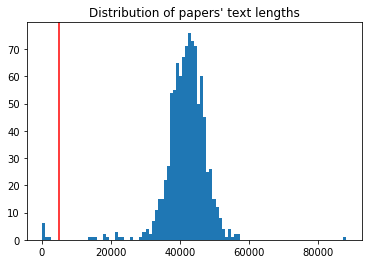

In [17]:
fig, ax = plt.subplots()
ax.hist(df['len'].values.tolist(), bins=100)
ax.set_title('Distribution of papers\' text lengths')
plt.axvline(x=5000, color='red')

There seems to be some odd occurences, like several papers have a length of zero or very close to zero, and an oulier on the righthand side of the plot. Which papers are these?

In [30]:
df[(df['len'] < 5000) | (df['len'] > 80000)].sort_values(by='len')

,paper,len
950,data/Zhou_Explicit_Loss-Error-Aware_Quantizati...,21
572,data/Ravi_Show_Me_a_CVPR_2018_paper.txt,54
753,data/Wang_Modulated_Convolutional_Networks_CVP...,110
435,data/Liu_Learning_Markov_Clustering_CVPR_2018_...,218
599,data/Saito_Maximum_Classifier_Discrepancy_CVPR...,385
177,data/Fang_Weakly_and_Semi_CVPR_2018_paper.txt,768
491,data/Mo_Uncalibrated_Photometric_Stereo_CVPR_2...,969
262,data/Hu_Sketch-a-Classifier_Sketch-Based_Photo...,2449
706,data/Tung_Reward_Learning_From_CVPR_2018_paper...,88331


The original PDF papers seem to be all right, but the parsed txt files have different degrees of parsing errors. Given the small amount of papers which have these issues, we decided to discard them from our analysis. 